In [25]:
import numpy as np
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from quantum_logical.interaction import ConversionGainInteraction
from qutip import Qobj, basis, tensor
from qutip.operators import sigmaz
from qutip.metrics import fidelity
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from quantum_logical.channel import Channel
from qutip import rand_dm

In [26]:
one_rho = basis(2, 1) * basis(2, 1).dag()  # |1><1|
initial_state = tensor([one_rho] * 2)

# # |00> + |01>
# initial_state = tensor([basis(2, 0), basis(2, 0)]) + tensor([basis(2, 0), basis(2, 1)])
# initial_state = initial_state * initial_state.dag()

# |10>
initial_state = tensor([basis(2, 1), basis(2, 0)])
initial_state = initial_state * initial_state.dag()

initial_state /= initial_state.norm()
initial_state = initial_state.full()
initial_state = Qobj(initial_state)
initial_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]

In [27]:
gc, gg = np.pi / 2, 0
trotter_dt = 0.1
duration = 1.0
H = ConversionGainInteraction(gc, gg)
iswap = H.construct_U(t=duration)
iswap = Qobj(iswap, dims=[[4], [4]])
iswap

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.-1.j 0.+0.j]
 [0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]

In [28]:
expected_state = iswap * Qobj(initial_state, dims=iswap.dims) * iswap.dag()
expected_state = Qobj(expected_state, dims=initial_state.dims)
expected_state

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [29]:
class ZZ(Channel):
    def __init__(self, chi, num_qubits=2):
        """
        Initialize with a given T2 dephasing time and number of qubits.
        """
        self.chi = chi
        self.num_qubits = num_qubits
        super().__init__(dims=2**num_qubits)

    # NOTE, override this method from the super class, because we don't want to
    # be able to extend this to multiple qubits. Definition is hardcoded for 2.
    def _init_kraus_operators(self):
        """
        Initialize and extend Kraus operators to multiple qubits.
        """
        self._E = self._create_single_qubit_operators()
        self._E = [np.array(E, dtype=complex) for E in self._E]
        self._verify_completeness()
        return self._E

    def _create_single_qubit_operators(self):
        """
        Create single-qubit Kraus operators for phase damping.
        """
        _zz = tensor([sigmaz()] * self.num_qubits)
        return [(-1j * self.chi * _zz * np.pi / 2 * self._trotter_dt).expm()]

In [30]:
T1, T2 = 1.0, 1.0
amp_damp_channel = AmplitudeDamping(T1, num_qubits=2)
phase_damp_channel = PhaseDamping(T2, num_qubits=2)


def multi_qubit_experiment(
    rho_initial, delay, chi, unitary, trotter_step_size=trotter_dt
):
    """Testing tradeoffs between fast iSWAP with strong cross-Kerr (ZZ)"""

    zz_channel = ZZ(chi, num_qubits=2)

    trotter = TrotterGroup(
        continuous_operators=[amp_damp_channel, phase_damp_channel, zz_channel],
        trotter_dt=trotter_step_size,
    )

    rho_final = trotter.apply(rho_initial, delay, discrete_unitary=unitary)

    if unitary is None:
        rho_expected = rho_initial
    else:
        rho_expected = unitary * rho_initial * unitary.dag()

    # Calculate the fidelity
    fid = fidelity(rho_expected, rho_final)
    return rho_final, fid

In [31]:
new_state, fid = multi_qubit_experiment(
    initial_state, delay=0.0, chi=0.0, unitary=iswap
)
print(fid)
new_state

1.0


Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:08<00:00, 12.45s/it]


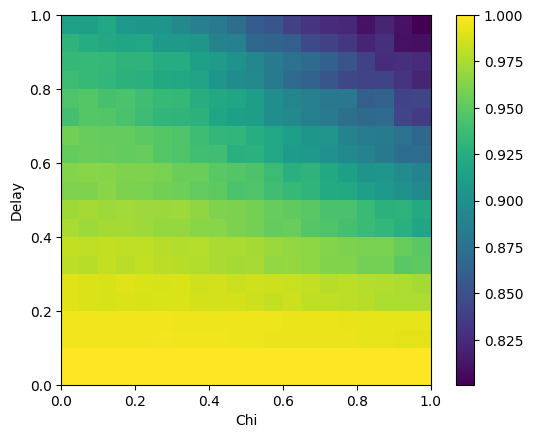

In [32]:
# define the range of delay and chi values
delay_range = np.linspace(0, 1, 20)
chi_range = np.linspace(0, 1, 20)
N = 100  # random initial states

# initialize the fidelity array
fidelity_array = np.zeros((len(delay_range), len(chi_range)))

# iterate over the delay and chi values
for i, delay in enumerate(tqdm(delay_range)):
    for j, chi in enumerate(chi_range):
        # initialize the fidelity sum
        fid_sum = 0

        # average over N=1000 random initial states
        for k in range(N):
            # generate a random initial state
            rho_initial = rand_dm(4)

            # run the experiment and add the fidelity to the sum
            _, fid = multi_qubit_experiment(rho_initial, delay, chi, unitary=iswap)
            fid_sum += fid

        # calculate the average fidelity and store it in the fidelity array
        fidelity_array[i, j] = fid_sum / N

# plot the fidelity array as a 2D heatmap
plt.imshow(fidelity_array, origin="lower", extent=[0, 1, 0, 1], cmap="viridis")
plt.xlabel("Chi")
plt.ylabel("Delay")
plt.colorbar()
plt.show()